In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
def _gen_l2_regularizer(use_l2_regularizer=True):
    return keras.regularizers.l2(1e-5) if use_l2_regularizer else None

In [4]:
def conv_block_34(input_layer,channel, stage, block_num, not_plane=True, use_l2_regularizer=True):
    
    BATCH_NORM_DECAY = 0.9
    BATCH_NORM_EPSILON = 1e-5
    
    bn_axis = 3 if keras.backend.image_data_format() == 'channels_last' else 1
    
    x = input_layer
    
    x = keras.layers.Conv2D(
        filters=channel,
        kernel_size=(3,3),
        padding='same',
        kernel_initializer=keras.initializers.he_normal,
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name= 'stage' + str(stage) + '_' + str(block_num) + '_conv1'
    )(x)
    
    x = keras.layers.BatchNormalization(
        axis=bn_axis,
        momentum=BATCH_NORM_DECAY,
        epsilon=BATCH_NORM_EPSILON,
        name = 'stage' + str(stage) + '_' + str(block_num) + '_bn1'
    )(x)
    
    x = keras.layers.Activation('relu')(x)
    
    
    x = keras.layers.Conv2D(
        filters=channel,
        kernel_size=(3,3),
        padding='same',
        kernel_initializer=keras.initializers.he_normal,
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name= 'stage' + str(stage) + '_' + str(block_num) + '_conv2'
    )(x)
    
    x = keras.layers.BatchNormalization(
        axis=bn_axis,
        momentum=BATCH_NORM_DECAY,
        epsilon=BATCH_NORM_EPSILON,
        name = 'stage' + str(stage) + '_' + str(block_num) + '_bn2'
    )(x)
    
    if not_plane:
        x = keras.layers.add([x, input_layer], name = 'stage' + str(stage) + '_' + str(block_num) + '_add')  # identity mapping
    x = keras.layers.Activation('relu')(x)
    
    return x

In [5]:
def stride_conv_block_34(input_layer,channel, stage, block_num, not_plane=True, use_l2_regularizer=True):
    
    BATCH_NORM_DECAY = 0.9
    BATCH_NORM_EPSILON = 1e-5
    
    bn_axis = 3 if keras.backend.image_data_format() == 'channels_last' else 1
    
    x = input_layer
    
    x = keras.layers.Conv2D(
        filters=channel,
        kernel_size=(3,3),
        strides=2,
        padding='same',
        kernel_initializer=keras.initializers.he_normal,
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name= 'stage' + str(stage) + '_' + str(block_num) + '_conv1'
    )(x)
    
    x = keras.layers.BatchNormalization(
        axis=bn_axis,
        momentum=BATCH_NORM_DECAY,
        epsilon=BATCH_NORM_EPSILON,
        name = 'stage' + str(stage) + '_' + str(block_num) + '_bn1'
    )(x)
    
    x = keras.layers.Activation('relu')(x)
    
    
    x = keras.layers.Conv2D(
        filters=channel,
        kernel_size=(3,3),
        padding='same',
        kernel_initializer=keras.initializers.he_normal,
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name= 'stage' + str(stage) + '_' + str(block_num) + '_conv2'
    )(x)
    
    x = keras.layers.BatchNormalization(
        axis=bn_axis,
        momentum=BATCH_NORM_DECAY,
        epsilon=BATCH_NORM_EPSILON,
        name = 'stage' + str(stage) + '_' + str(block_num) + '_bn2'
    )(x)
    
    
    
    shortcut_proj = keras.layers.Conv2D(
        filters=channel,
        kernel_size=(3,3),
        strides=2,
        padding='same',
        kernel_initializer=keras.initializers.he_normal,
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name= 'stage' + str(stage) + '_' + str(block_num) + '_shortcut'
    )(input_layer)
    shortcut_proj = keras.layers.BatchNormalization(
        axis=bn_axis,
        momentum=BATCH_NORM_DECAY,
        epsilon=BATCH_NORM_EPSILON,
        name = 'stage' + str(stage) + '_' + str(block_num) + '_shortcut_bn'
    )(shortcut_proj)
    
    if not_plane:
        x = keras.layers.add([x, shortcut_proj], name = 'stage' + str(stage) + '_' + str(block_num) + 'add')  # identity mapping
    x = keras.layers.Activation('relu')(x)
    
    return x

In [6]:
def stage1(input_layer, use_l2_regularizer=True):
    
    L2_WEIGHT_DECAY = 1e-5
    BATCH_NORM_DECAY = 0.9
    BATCH_NORM_EPSILON = 1e-5
    
    bn_axis = 3 if keras.backend.image_data_format() == 'channels_last' else 1
    
    input_img = input_layer
    
    x = keras.layers.ZeroPadding2D(padding=3)(input_img)
    
    x = keras.layers.Conv2D(
        filters=64,
        kernel_size=(7,7),
        strides=2,
        padding='same',
        kernel_initializer=keras.initializers.he_normal,
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name= 'stage1_conv2d'
    )(input_img)
    
    x = keras.layers.BatchNormalization(
        axis=bn_axis,
        momentum=BATCH_NORM_DECAY,
        epsilon=BATCH_NORM_EPSILON,
        name = 'stage1_BN'
    )(x)
    
    x = keras.layers.Activation('relu')(x)
    
    #x = keras.layers.ZeroPadding2D(padding=1)(x)
    x = keras.layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)
    
    return x

In [7]:
def build_resnet34(input_shape=(32,32,3), channel=[64,128,256,512], block_num=[3,4,6,3], not_plane=True, num_classes=10, use_l2_regularizer=True):
    
    L2_WEIGHT_DECAY = 1e-5
    BATCH_NORM_DECAY = 0.9
    BATCH_NORM_EPSILON = 1e-5
    
    input_layer = keras.layers.Input(shape=input_shape) 
    
    stage1_output = stage1(input_layer, use_l2_regularizer=use_l2_regularizer)
    
    x = stage1_output
    
    for i in range(len(channel)):
        #print('stage:',i+2)
        if i == 0 :
            x = conv_block_34(x,channel[i], i+2, 1, not_plane, use_l2_regularizer=use_l2_regularizer)
        else :
            x = stride_conv_block_34(x,channel[i], i+2, 1, not_plane, use_l2_regularizer=use_l2_regularizer)
        for j in range(2,block_num[i]+1):
            #print('block:',j)
            x = conv_block_34(x,channel[i], i+2, j,not_plane, use_l2_regularizer=use_l2_regularizer)
    
    x = keras.layers.GlobalAveragePooling2D(name='average_pool')(x)
    
    #x = keras.layers.AveragePooling2D((1,1), name='average_pool')(x)
    #x = keras.layers.Flatten(name='flatten')(x)
    
    output = keras.layers.Dense(
        num_classes,
        kernel_initializer=keras.initializers.RandomNormal(stddev=0.01),
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        bias_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name='fc1000')(x)
    
    '''output = keras.layers.Dense(
        num_classes,
        name='fc1000')(x)'''
    
    output = keras.layers.Activation('softmax', dtype='float32')(output)
    
    model = keras.Model(inputs=input_layer, outputs=output)  
    
    return model

# Resnet-50

In [8]:
def conv_block_50(input_layer,channel, stage, block_num, not_plane=True, use_l2_regularizer=True):
    
    BATCH_NORM_DECAY = 0.9
    BATCH_NORM_EPSILON = 1e-5
    
    bn_axis = 3 if keras.backend.image_data_format() == 'channels_last' else 1
    
    x = input_layer
    
    x = keras.layers.Conv2D(
        filters=channel,
        kernel_size=(1,1),
        kernel_initializer=keras.initializers.he_normal,
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name= 'stage' + str(stage) + '_' + str(block_num) + '_conv1'
    )(x)
    
    x = keras.layers.BatchNormalization(
        axis=bn_axis,
        momentum=BATCH_NORM_DECAY,
        epsilon=BATCH_NORM_EPSILON,
        name = 'stage' + str(stage) + '_' + str(block_num) + '_bn1'
    )(x)
    
    x = keras.layers.Activation('relu')(x)
    
    x = keras.layers.Conv2D(
        filters=channel,
        kernel_size=(3,3),
        padding='same',
        kernel_initializer=keras.initializers.he_normal,
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name= 'stage' + str(stage) + '_' + str(block_num) + '_conv2'
    )(x)
    
    x = keras.layers.BatchNormalization(
        axis=bn_axis,
        momentum=BATCH_NORM_DECAY,
        epsilon=BATCH_NORM_EPSILON,
        name = 'stage' + str(stage) + '_' + str(block_num) + '_bn2'
    )(x)
    
    x = keras.layers.Activation('relu')(x)
    
    
    x = keras.layers.Conv2D(
        filters=channel*4,
        kernel_size=(1,1),
        kernel_initializer=keras.initializers.he_normal,
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name= 'stage' + str(stage) + '_' + str(block_num) + '_conv3'
    )(x)
    
    x = keras.layers.BatchNormalization(
        axis=bn_axis,
        momentum=BATCH_NORM_DECAY,
        epsilon=BATCH_NORM_EPSILON,
        name = 'stage' + str(stage) + '_' + str(block_num) + '_bn3'
    )(x)
   
    
    if not_plane:
        x = keras.layers.add([x, input_layer], name = 'stage' + str(stage) + '_' + str(block_num) + '_add')  # identity mapping
    x = keras.layers.Activation('relu')(x)
    
    return x

In [9]:
def stride_conv_block_50(input_layer,channel, stage, block_num, not_plane, stride = 2, use_l2_regularizer=True):
    
    BATCH_NORM_DECAY = 0.9
    BATCH_NORM_EPSILON = 1e-5
    
    bn_axis = 3 if keras.backend.image_data_format() == 'channels_last' else 1
    
    x = input_layer
    
    x = keras.layers.Conv2D(
        filters=channel,
        kernel_size=(1,1),
        strides=stride,
        kernel_initializer=keras.initializers.he_normal,
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name= 'stage' + str(stage) + '_' + str(block_num) + '_conv1'
    )(x)
    
    x = keras.layers.BatchNormalization(
        axis=bn_axis,
        momentum=BATCH_NORM_DECAY,
        epsilon=BATCH_NORM_EPSILON,
        name = 'stage' + str(stage) + '_' + str(block_num) + '_bn1'
    )(x)
    
    x = keras.layers.Activation('relu')(x)
    
    x = keras.layers.Conv2D(
        filters=channel,
        kernel_size=(3,3),
        padding='same',
        kernel_initializer=keras.initializers.he_normal,
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name= 'stage' + str(stage) + '_' + str(block_num) + '_conv2'
    )(x)
    
    x = keras.layers.BatchNormalization(
        axis=bn_axis,
        momentum=BATCH_NORM_DECAY,
        epsilon=BATCH_NORM_EPSILON,
        name = 'stage' + str(stage) + '_' + str(block_num) + '_bn2'
    )(x)
    
    x = keras.layers.Activation('relu')(x)
    
    
    x = keras.layers.Conv2D(
        filters=channel*4,
        kernel_size=(1,1),
        kernel_initializer=keras.initializers.he_normal,
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name= 'stage' + str(stage) + '_' + str(block_num) + '_conv3'
    )(x)
    
    x = keras.layers.BatchNormalization(
        axis=bn_axis,
        momentum=BATCH_NORM_DECAY,
        epsilon=BATCH_NORM_EPSILON,
        name = 'stage' + str(stage) + '_' + str(block_num) + '_bn3'
    )(x)
    
    
    
    shortcut = keras.layers.Conv2D(
        filters=channel*4,
        kernel_size=(1,1),
        strides=stride,
        kernel_initializer=keras.initializers.he_normal,
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name= 'stage' + str(stage) + '_' + str(block_num) + '_shortcut'
    )(input_layer)
    shortcut = keras.layers.BatchNormalization(
        axis=bn_axis,
        momentum=BATCH_NORM_DECAY,
        epsilon=BATCH_NORM_EPSILON,
        name = 'stage' + str(stage) + '_' + str(block_num) + '_shortcut_bn'
    )(shortcut)
    
    if not_plane:
        x = keras.layers.add([x, shortcut], name = 'stage' + str(stage) + '_' + str(block_num) + 'add')  # identity mapping
    x = keras.layers.Activation('relu')(x)
    
    return x

In [10]:
def build_resnet50(input_shape=(32,32,3), channel=[64,128,256,512], block_num=[3,4,6,3], not_plane=True, num_classes=10, use_l2_regularizer=True):
    
    L2_WEIGHT_DECAY = 1e-5
    BATCH_NORM_DECAY = 0.9
    BATCH_NORM_EPSILON = 1e-5
    
    input_layer = keras.layers.Input(shape=input_shape) 
    
    stage1_output = stage1(input_layer)
    
    x = stage1_output
    
    for i in range(len(channel)):
        #print('stage:',i+2)
        if i == 0 :
            x = stride_conv_block_50(x,channel[i], i+2, 1, not_plane, stride=1, use_l2_regularizer=use_l2_regularizer)
        else :
            x = stride_conv_block_50(x,channel[i], i+2, 1, not_plane, use_l2_regularizer=use_l2_regularizer)
        #x = stride_conv_block_50(x,channel[i], i+2, 1, not_plane)
        for j in range(2,block_num[i]+1):
            #print('block:',j)
            x = conv_block_50(x,channel[i], i+2, j, not_plane, use_l2_regularizer=use_l2_regularizer)
    
    x = keras.layers.GlobalAveragePooling2D(name='average_pool')(x)
    
    #x = keras.layers.AveragePooling2D((1,1), name='average_pool')(x)
    #x = keras.layers.Flatten(name='flatten')(x)
    output = keras.layers.Dense(
        num_classes,
        kernel_initializer=keras.initializers.RandomNormal(stddev=0.01),
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        bias_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name='fc1000')(x)
    '''output = keras.layers.Dense(
        num_classes,
        name='fc1000')(x)'''
    output = keras.layers.Activation('softmax', dtype='float32')(output)
    
    model = keras.Model(inputs=input_layer, outputs=output)  
    
    return model

In [11]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

ds_train, train_info = tfds.load('cats_vs_dogs', split='train[:80%]', as_supervised=True,with_info=True,)
ds_test, test_info= tfds.load('cats_vs_dogs', split='train[-20%:]', as_supervised=True,with_info=True)

In [12]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [13]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [14]:
BATCH_SIZE = 32
EPOCH = 20

In [15]:
ds_train_batch = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test_batch = apply_normalize_on_dataset(ds_test, True, batch_size=BATCH_SIZE)

In [16]:
model34 = build_resnet34(input_shape=(224,224,3), num_classes=2, use_l2_regularizer=False)

model34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stage1_conv2d (Conv2D)          (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
stage1_BN (BatchNormalization)  (None, 112, 112, 64) 256         stage1_conv2d[0][0]              
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           stage1_BN[0][0]                  
______________________________________________________________________________________________

In [17]:
model50 = build_resnet50(input_shape=(224,224,3), num_classes=2, use_l2_regularizer=False)

model50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stage1_conv2d (Conv2D)          (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
stage1_BN (BatchNormalization)  (None, 112, 112, 64) 256         stage1_conv2d[0][0]              
__________________________________________________________________________________________________
activation_34 (Activation)      (None, 112, 112, 64) 0           stage1_BN[0][0]                  
____________________________________________________________________________________________

In [18]:
plain_model34 = build_resnet34(input_shape=(224,224,3), not_plane=False, num_classes=2, use_l2_regularizer=False)

plain_model34.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
stage1_conv2d (Conv2D)       (None, 112, 112, 64)      9472      
_________________________________________________________________
stage1_BN (BatchNormalizatio (None, 112, 112, 64)      256       
_________________________________________________________________
activation_84 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
stage2_1_conv1 (Conv2D)      (None, 56, 56, 64)        36928     
_________________________________________________________________
stage2_1_bn1 (BatchNormaliza (None, 56, 56, 64)        256 

In [19]:
plain_model50 = build_resnet34(input_shape=(224,224,3), not_plane=False, num_classes=2, use_l2_regularizer=False)

plain_model50.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
stage1_conv2d (Conv2D)       (None, 112, 112, 64)      9472      
_________________________________________________________________
stage1_BN (BatchNormalizatio (None, 112, 112, 64)      256       
_________________________________________________________________
activation_118 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
stage2_1_conv1 (Conv2D)      (None, 56, 56, 64)        36928     
_________________________________________________________________
stage2_1_bn1 (BatchNormaliza (None, 56, 56, 64)        256 

# Resnet34

In [21]:
model34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)),
    metrics=['accuracy'],
)

'''
model34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9, decay=0.0001, nesterov=False),
    metrics=['accuracy'],
)
'''
history_34 = model34.fit(
    ds_train_batch,
    steps_per_epoch=int(18610/BATCH_SIZE),
    validation_steps=int(4652/BATCH_SIZE),
    epochs=20,
    validation_data=ds_test_batch,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
581/581 [==============================] - 104s 153ms/step - loss: 0.7896 - accuracy: 0.5524 - val_loss: 0.5992 - val_accuracy: 0.6912
Epoch 2/20
581/581 [==============================] - 81s 140ms/step - loss: 0.6049 - accuracy: 0.6773 - val_loss: 0.6040 - val_accuracy: 0.7047
Epoch 3/20
581/581 [==============================] - 81s 140ms/step - loss: 0.5263 - accuracy: 0.7351 - val_loss: 0.5635 - val_accuracy: 0.7315
Epoch 4/20
581/581 [==============================] - 81s 139ms/step - loss: 0.4506 - accuracy: 0.7916 - val_loss: 0.7637 - val_accuracy: 0.7037
Epoch 5/20
581/581 [==============================] - 81s 139ms/step - loss: 0.3943 - accuracy: 0.8251 - val_loss: 0.9392 - val_accuracy: 0.6597
Epoch 6/20
581/581 [==============================] - 82s 142ms/step - loss: 0.3285 - accuracy: 0.8612 - val_loss: 0.5959 - val_accuracy: 0.7728
Epoch 7/20
581/581 [==============================] - 84s 145ms/step - loss: 0.2854 - accuracy: 0.8778 - val_loss: 0.4682 - val_a

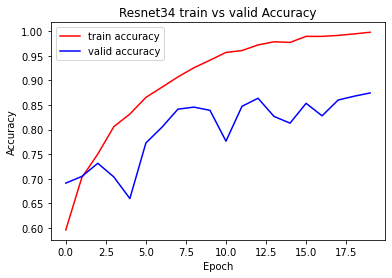

In [33]:
import matplotlib.pyplot as plt

plt.plot(history_34.history['accuracy'], 'r')
plt.plot(history_34.history['val_accuracy'], 'b')
plt.title('Resnet34 train vs valid Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train accuracy', 'valid accuracy'], loc='upper left')
plt.show()

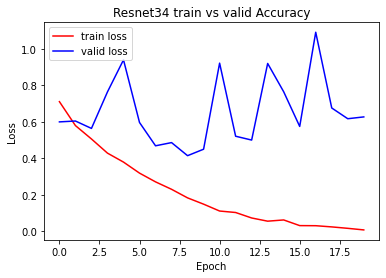

In [34]:
plt.plot(history_34.history['loss'], 'r')
plt.plot(history_34.history['val_loss'], 'b')
plt.title('Resnet34 train vs valid Accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train loss', 'valid loss'], loc='upper left')
plt.show()

# Resnet 50

In [43]:
model50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)),
    metrics=['accuracy'],
)

history_50 = model50.fit(
    ds_train_batch,
    steps_per_epoch=int(18610/BATCH_SIZE),
    validation_steps=int(4652/BATCH_SIZE),
    epochs=20,
    validation_data=ds_test_batch,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
581/581 [==============================] - 143s 235ms/step - loss: 0.1515 - accuracy: 0.9434 - val_loss: 0.9304 - val_accuracy: 0.8086
Epoch 2/20
581/581 [==============================] - 137s 235ms/step - loss: 0.1442 - accuracy: 0.9431 - val_loss: 0.6526 - val_accuracy: 0.8302
Epoch 3/20
581/581 [==============================] - 137s 236ms/step - loss: 0.1185 - accuracy: 0.9553 - val_loss: 0.8530 - val_accuracy: 0.8116
Epoch 4/20
581/581 [==============================] - 137s 236ms/step - loss: 0.1057 - accuracy: 0.9613 - val_loss: 0.7546 - val_accuracy: 0.8448
Epoch 5/20
581/581 [==============================] - 138s 237ms/step - loss: 0.0794 - accuracy: 0.9697 - val_loss: 1.0230 - val_accuracy: 0.8397
Epoch 6/20
581/581 [==============================] - 137s 236ms/step - loss: 0.0702 - accuracy: 0.9747 - val_loss: 1.3447 - val_accuracy: 0.8369
Epoch 7/20
581/581 [==============================] - 137s 237ms/step - loss: 0.0594 - accuracy: 0.9784 - val_loss: 1.0524 -

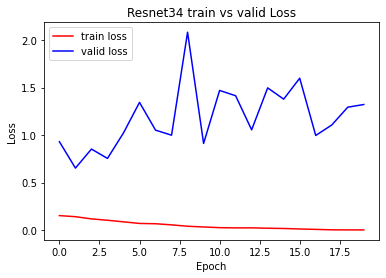

In [44]:
plt.plot(history_50.history['loss'], 'r')
plt.plot(history_50.history['val_loss'], 'b')
plt.title('Resnet34 train vs valid Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train loss', 'valid loss'], loc='upper left')
plt.show()

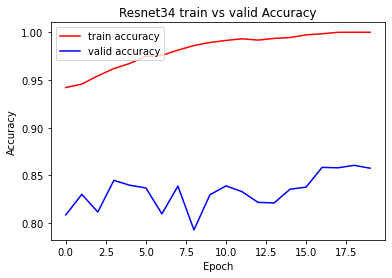

In [45]:
plt.plot(history_50.history['accuracy'], 'r')
plt.plot(history_50.history['val_accuracy'], 'b')
plt.title('Resnet34 train vs valid Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train accuracy', 'valid accuracy'], loc='upper left')
plt.show()

# resnet34 vs resnet50

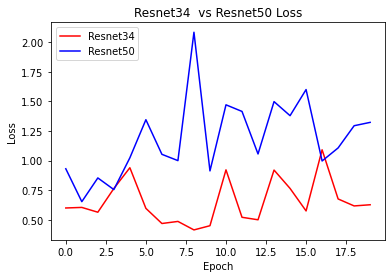

In [46]:
plt.plot(history_34.history['val_loss'], 'r')
plt.plot(history_50.history['val_loss'], 'b')
plt.title('Resnet34  vs Resnet50 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Resnet34', 'Resnet50'], loc='upper left')
plt.show()

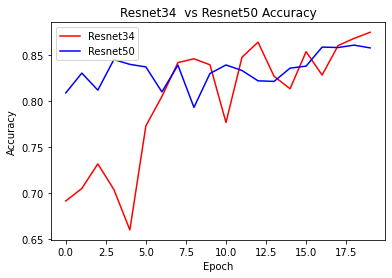

In [47]:
plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_50.history['val_accuracy'], 'b')
plt.title('Resnet34  vs Resnet50 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Resnet34', 'Resnet50'], loc='upper left')
plt.show()

# Plain34

In [23]:
plain_model34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)),
    metrics=['accuracy'],
)

'''
model34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9, decay=0.0001, nesterov=False),
    metrics=['accuracy'],
)
'''
history_plain34 = plain_model34.fit(
    ds_train_batch,
    steps_per_epoch=int(18610/BATCH_SIZE),
    validation_steps=int(4652/BATCH_SIZE),
    epochs=20,
    validation_data=ds_test_batch,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
581/581 [==============================] - 77s 123ms/step - loss: 0.6937 - accuracy: 0.5178 - val_loss: 0.6866 - val_accuracy: 0.5784
Epoch 2/20
581/581 [==============================] - 72s 124ms/step - loss: 0.6733 - accuracy: 0.5809 - val_loss: 0.6714 - val_accuracy: 0.6200
Epoch 3/20
581/581 [==============================] - 72s 124ms/step - loss: 0.6452 - accuracy: 0.6305 - val_loss: 0.7160 - val_accuracy: 0.5916
Epoch 4/20
581/581 [==============================] - 72s 124ms/step - loss: 0.6272 - accuracy: 0.6523 - val_loss: 0.6161 - val_accuracy: 0.6683
Epoch 5/20
581/581 [==============================] - 73s 125ms/step - loss: 0.6027 - accuracy: 0.6660 - val_loss: 0.5875 - val_accuracy: 0.6862
Epoch 6/20
581/581 [==============================] - 73s 125ms/step - loss: 0.5699 - accuracy: 0.6997 - val_loss: 0.5917 - val_accuracy: 0.6981
Epoch 7/20
581/581 [==============================] - 73s 125ms/step - loss: 0.5257 - accuracy: 0.7325 - val_loss: 0.5304 - val_ac

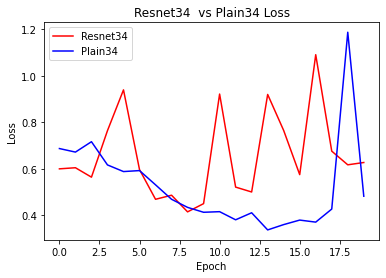

In [41]:
plt.plot(history_34.history['val_loss'], 'r')
plt.plot(history_plain34.history['val_loss'], 'b')
plt.title('Resnet34  vs Plain34 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Resnet34', 'Plain34'], loc='upper left')
plt.show()

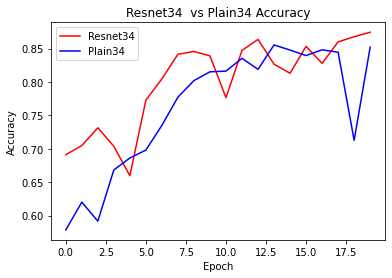

In [42]:
plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_plain34.history['val_accuracy'], 'b')
plt.title('Resnet34  vs Plain34 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Resnet34', 'Plain34'], loc='upper left')
plt.show()

# Plain50

In [48]:
plain_model50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)),
    metrics=['accuracy'],
)

history_plain50 = plain_model50.fit(
    ds_train_batch,
    steps_per_epoch=int(18610/BATCH_SIZE),
    validation_steps=int(4652/BATCH_SIZE),
    epochs=20,
    validation_data=ds_test_batch,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
581/581 [==============================] - 77s 124ms/step - loss: 0.0878 - accuracy: 0.9667 - val_loss: 0.8394 - val_accuracy: 0.7914
Epoch 2/20
581/581 [==============================] - 72s 125ms/step - loss: 0.0982 - accuracy: 0.9609 - val_loss: 0.4782 - val_accuracy: 0.8560
Epoch 3/20
581/581 [==============================] - 73s 125ms/step - loss: 0.0765 - accuracy: 0.9710 - val_loss: 0.6024 - val_accuracy: 0.8599
Epoch 4/20
581/581 [==============================] - 73s 125ms/step - loss: 0.0572 - accuracy: 0.9783 - val_loss: 0.5233 - val_accuracy: 0.8692
Epoch 5/20
581/581 [==============================] - 73s 125ms/step - loss: 0.0565 - accuracy: 0.9776 - val_loss: 0.5513 - val_accuracy: 0.8759
Epoch 6/20
581/581 [==============================] - 73s 126ms/step - loss: 0.0373 - accuracy: 0.9877 - val_loss: 0.5056 - val_accuracy: 0.8772
Epoch 7/20
581/581 [==============================] - 73s 126ms/step - loss: 0.0377 - accuracy: 0.9855 - val_loss: 0.5615 - val_ac

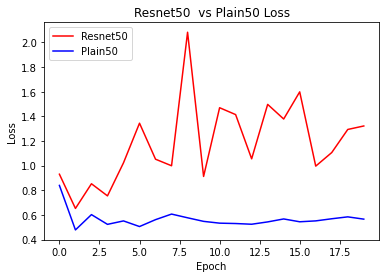

In [49]:
plt.plot(history_50.history['val_loss'], 'r')
plt.plot(history_plain50.history['val_loss'], 'b')
plt.title('Resnet50  vs Plain50 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Resnet50', 'Plain50'], loc='upper left')
plt.show()

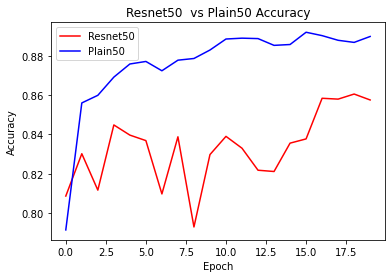

In [51]:
plt.plot(history_50.history['val_accuracy'], 'r')
plt.plot(history_plain50.history['val_accuracy'], 'b')
plt.title('Resnet50  vs Plain50 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Resnet50', 'Plain50'], loc='upper left')
plt.show()

# L2 decay 적용

In [25]:
model34_l2 = build_resnet34(input_shape=(224,224,3), num_classes=2, use_l2_regularizer=True)

model34_l2.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stage1_conv2d (Conv2D)          (None, 112, 112, 64) 9472        input_5[0][0]                    
__________________________________________________________________________________________________
stage1_BN (BatchNormalization)  (None, 112, 112, 64) 256         stage1_conv2d[0][0]              
__________________________________________________________________________________________________
activation_152 (Activation)     (None, 112, 112, 64) 0           stage1_BN[0][0]                  
____________________________________________________________________________________________

In [26]:
model34_l2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)),
    metrics=['accuracy'],
)

history34_l2 = model34_l2.fit(
    ds_train_batch,
    steps_per_epoch=int(18610/BATCH_SIZE),
    validation_steps=int(4652/BATCH_SIZE),
    epochs=20,
    validation_data=ds_test_batch,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
581/581 [==============================] - 88s 141ms/step - loss: 0.9811 - accuracy: 0.5513 - val_loss: 0.9317 - val_accuracy: 0.5420
Epoch 2/20
581/581 [==============================] - 82s 141ms/step - loss: 0.7452 - accuracy: 0.7050 - val_loss: 0.7056 - val_accuracy: 0.7353
Epoch 3/20
581/581 [==============================] - 82s 141ms/step - loss: 0.6820 - accuracy: 0.7546 - val_loss: 0.7265 - val_accuracy: 0.7433
Epoch 4/20
581/581 [==============================] - 82s 141ms/step - loss: 0.6170 - accuracy: 0.7996 - val_loss: 0.6087 - val_accuracy: 0.8045
Epoch 5/20
581/581 [==============================] - 82s 141ms/step - loss: 0.5479 - accuracy: 0.8348 - val_loss: 0.5695 - val_accuracy: 0.8181
Epoch 6/20
581/581 [==============================] - 82s 141ms/step - loss: 0.4961 - accuracy: 0.8579 - val_loss: 0.6056 - val_accuracy: 0.8088
Epoch 7/20
581/581 [==============================] - 82s 141ms/step - loss: 0.4334 - accuracy: 0.8923 - val_loss: 0.5533 - val_ac

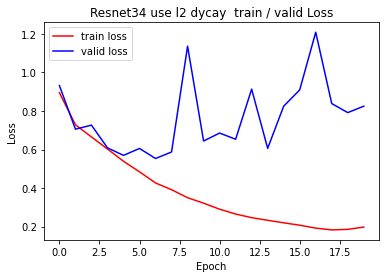

In [55]:
plt.plot(history34_l2.history['loss'], 'r')
plt.plot(history34_l2.history['val_loss'], 'b')
plt.title('Resnet34 use l2 dycay  train / valid Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train loss', 'valid loss'], loc='upper left')
plt.show()

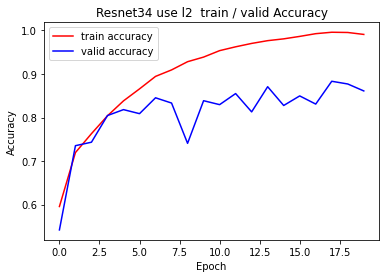

In [54]:
plt.plot(history34_l2.history['accuracy'], 'r')
plt.plot(history34_l2.history['val_accuracy'], 'b')
plt.title('Resnet34 use l2  train / valid Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train accuracy', 'valid accuracy'], loc='upper left')
plt.show()

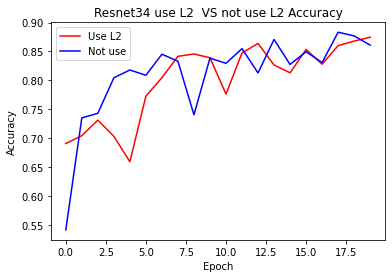

In [56]:
plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history34_l2.history['val_accuracy'], 'b')
plt.title('Resnet34 use L2  VS not use L2 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Use L2', 'Not use'], loc='upper left')
plt.show()

In [29]:
model50_l2 = build_resnet50(input_shape=(224,224,3), num_classes=2, use_l2_regularizer=True)

model50_l2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)),
    metrics=['accuracy'],
)

history50_l2 = model50_l2.fit(
    ds_train_batch,
    steps_per_epoch=int(18610/BATCH_SIZE),
    validation_steps=int(4652/BATCH_SIZE),
    epochs=20,
    validation_data=ds_test_batch,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
581/581 [==============================] - 144s 236ms/step - loss: 2.0656 - accuracy: 0.5361 - val_loss: 1.2942 - val_accuracy: 0.5978
Epoch 2/20
581/581 [==============================] - 137s 237ms/step - loss: 1.3035 - accuracy: 0.5910 - val_loss: 1.2643 - val_accuracy: 0.6358
Epoch 3/20
581/581 [==============================] - 138s 238ms/step - loss: 1.2511 - accuracy: 0.6092 - val_loss: 2.0155 - val_accuracy: 0.4972
Epoch 4/20
581/581 [==============================] - 138s 238ms/step - loss: 1.1954 - accuracy: 0.6519 - val_loss: 1.5518 - val_accuracy: 0.5922
Epoch 5/20
581/581 [==============================] - 138s 237ms/step - loss: 1.1639 - accuracy: 0.6835 - val_loss: 1.3865 - val_accuracy: 0.6970
Epoch 6/20
581/581 [==============================] - 138s 237ms/step - loss: 1.1079 - accuracy: 0.7148 - val_loss: 1.0687 - val_accuracy: 0.7478
Epoch 7/20
581/581 [==============================] - 138s 238ms/step - loss: 1.0643 - accuracy: 0.7469 - val_loss: 1.1303 -

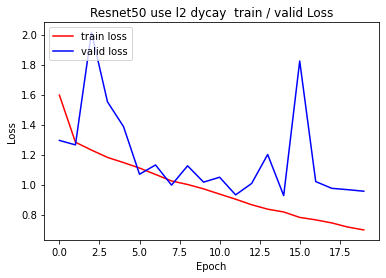

In [57]:
plt.plot(history50_l2.history['loss'], 'r')
plt.plot(history50_l2.history['val_loss'], 'b')
plt.title('Resnet50 use l2 dycay  train / valid Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train loss', 'valid loss'], loc='upper left')
plt.show()

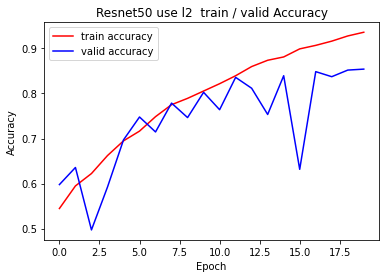

In [58]:
plt.plot(history50_l2.history['accuracy'], 'r')
plt.plot(history50_l2.history['val_accuracy'], 'b')
plt.title('Resnet50 use l2  train / valid Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train accuracy', 'valid accuracy'], loc='upper left')
plt.show()

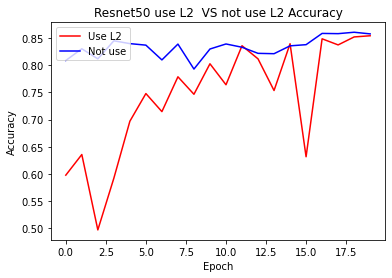

In [62]:
plt.plot(history50_l2.history['val_accuracy'], 'r')
plt.plot(history_50.history['val_accuracy'], 'b')
plt.title('Resnet50 use L2  VS not use L2 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Use L2', 'Not use'], loc='upper left')
plt.show()

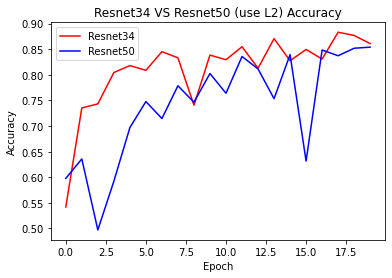

In [61]:
plt.plot(history34_l2.history['val_accuracy'], 'r')
plt.plot(history50_l2.history['val_accuracy'], 'b')
plt.title('Resnet34 VS Resnet50 (use L2) Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Resnet34', 'Resnet50'], loc='upper left')
plt.show()

In [30]:
plain_model34_l2 = build_resnet34(input_shape=(224,224,3), not_plane=True, num_classes=2, use_l2_regularizer=True)

plain_model34_l2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)),
    metrics=['accuracy'],
)

history_plain34_l2 = plain_model34_l2.fit(
    ds_train_batch,
    steps_per_epoch=int(18610/BATCH_SIZE),
    validation_steps=int(4652/BATCH_SIZE),
    epochs=20,
    validation_data=ds_test_batch,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
581/581 [==============================] - 87s 139ms/step - loss: 0.9563 - accuracy: 0.5532 - val_loss: 0.8034 - val_accuracy: 0.6687
Epoch 2/20
581/581 [==============================] - 81s 140ms/step - loss: 0.7765 - accuracy: 0.6758 - val_loss: 0.7790 - val_accuracy: 0.6996
Epoch 3/20
581/581 [==============================] - 81s 140ms/step - loss: 0.7009 - accuracy: 0.7389 - val_loss: 1.4692 - val_accuracy: 0.5759
Epoch 4/20
581/581 [==============================] - 82s 140ms/step - loss: 0.6269 - accuracy: 0.7849 - val_loss: 0.6026 - val_accuracy: 0.8121
Epoch 5/20
581/581 [==============================] - 82s 141ms/step - loss: 0.5687 - accuracy: 0.8221 - val_loss: 0.5519 - val_accuracy: 0.8328
Epoch 6/20
581/581 [==============================] - 82s 141ms/step - loss: 0.5175 - accuracy: 0.8504 - val_loss: 0.6462 - val_accuracy: 0.7972
Epoch 7/20
581/581 [==============================] - 82s 141ms/step - loss: 0.4578 - accuracy: 0.8757 - val_loss: 0.5506 - val_ac

In [31]:
plain_model50_l2 = build_resnet50(input_shape=(224,224,3), not_plane=True, num_classes=2, use_l2_regularizer=True)

plain_model50_l2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)),
    metrics=['accuracy'],
)

history_plain50_l2 = plain_model50_l2.fit(
    ds_train_batch,
    steps_per_epoch=int(18610/BATCH_SIZE),
    validation_steps=int(4652/BATCH_SIZE),
    epochs=20,
    validation_data=ds_test_batch,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
581/581 [==============================] - 144s 236ms/step - loss: 2.0819 - accuracy: 0.5224 - val_loss: 1.2335 - val_accuracy: 0.5922
Epoch 2/20
581/581 [==============================] - 138s 237ms/step - loss: 1.2927 - accuracy: 0.5762 - val_loss: 1.1722 - val_accuracy: 0.6401
Epoch 3/20
581/581 [==============================] - 138s 237ms/step - loss: 1.2496 - accuracy: 0.6199 - val_loss: 2.0161 - val_accuracy: 0.6416
Epoch 4/20
581/581 [==============================] - 138s 238ms/step - loss: 1.2935 - accuracy: 0.6370 - val_loss: 2.5151 - val_accuracy: 0.6134
Epoch 5/20
581/581 [==============================] - 138s 238ms/step - loss: 1.2209 - accuracy: 0.6806 - val_loss: 1.2701 - val_accuracy: 0.6731
Epoch 6/20
581/581 [==============================] - 138s 238ms/step - loss: 1.1579 - accuracy: 0.7013 - val_loss: 1.3229 - val_accuracy: 0.6821
Epoch 7/20
581/581 [==============================] - 139s 239ms/step - loss: 1.0776 - accuracy: 0.7394 - val_loss: 1.1306 -